In [1]:
import cv2 as cv
import numpy as np
from imutils import contours
import kociemba
# from datetime import datetime

In [2]:
from sklearn.cluster import KMeans
from skimage.color import rgb2lab, deltaE_cie76#,deltaE_ciede2000,deltaE_ciede94

In [3]:
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

In [5]:
def identify_color(image,color_list,threshold=60):
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image_color = get_colors(image, 1, False)
#     print(image_color)
    image_color = rgb2lab(np.uint8(np.asarray([[image_color]])))
    possible_match = {}
    for val in color_list:
#         print(f"val is {val}")
        curr_color = rgb2lab(np.uint8(np.asarray([color_list[val]])))
        diff = deltaE_cie76(image_color, curr_color)
#         diff = deltaE_ciede94(image_color, curr_color)
        
#         diff = deltaE_ciede2000(image_color, curr_color)
        
#         print(diff[0][0][0])
        if (diff < threshold):
            possible_match[int(diff[0][0][0])] = val
    
    possible_match = dict(sorted(possible_match.items()))
    print(possible_match)
    return list(possible_match.values())[0]

In [6]:
def get_image(image_path):
    image = cv.imread(image_path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    return image

In [7]:
def get_colors(image, number_of_colors, show_chart):
    
#     modified_image = image.copy()
    modified_image = cv.resize(image, (600, 400), interpolation = cv.INTER_AREA)
    modified_image = modified_image.reshape(modified_image.shape[0]*modified_image.shape[1], 3)
    
    clf = KMeans(n_clusters = number_of_colors)
    labels = clf.fit_predict(modified_image)
    
    counts = Counter(labels)
    # sort to ensure correct color percentage
    counts = dict(sorted(counts.items()))
    
    center_colors = clf.cluster_centers_
    # We get ordered colors by iterating through the keys
    ordered_colors = [center_colors[i] for i in counts.keys()]
    hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()]
    rgb_colors = [ordered_colors[i] for i in counts.keys()]

    if (show_chart):
        plt.figure(figsize = (8, 6))
        plt.pie(counts.values(), labels = hex_colors, colors = hex_colors)
#     print("inside rgb_colors is ",rgb_colors)
    return rgb_colors

[array([ 26.75747888,  59.11207822, 111.9013861 ]),
 array([154.06384647,  25.13592804,  19.39408348]),
 array([180.25348464, 184.73235153, 188.40587954]),
 array([192.42392271, 173.92311759,   2.62741234]),
 array([203.3298165 ,  95.42280219,  14.25139453]),
 array([ 7.74207151, 89.74207151, 66.08612766])]

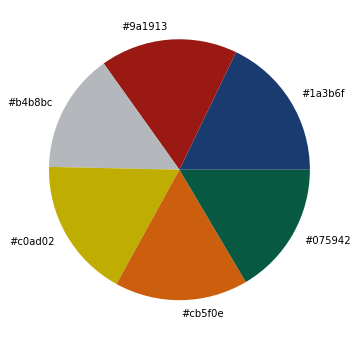

In [8]:
get_colors(get_image('images/colors.jpg'), 6, True)

In [9]:
# [array([184.041793  ,  86.70871917,  27.80222077]), orange
#  array([19.65844721, 99.40294004, 50.53381903]),
#  array([180.95730246, 156.87009815,  11.83821068]),
#  array([23.40360149, 40.62052261, 92.8763946 ]),
#  array([140.70223789,  31.6402395 ,  27.26374793])] red


COLORS = {
    'F': [7,100,67], #green
    'U': [180,185,189], #white
    'D': [180,156,11],#yellow
    'B' : [26,59,120],#blue
    'L':[201,92,19],#orange
    'R':[190,31,42] #red
#     'Green': [7,89,67],
#     'White': [180,185,189],
#     'Yellow': [180,156,11],
#     'Blue' : [26,59,120],
#     'Orange':[201,92,19],
#     'Red':[190,31,33]
}

# COLORS = {
#     'Green': [7,89,67],
#     'White': [180,185,189],
#     'Yellow': [193,177,2],
#     'Blue' : [26,59,112],
#     'Orange':[180,95,13],
#     'Red':[140,30,37]
# }

In [10]:
# working
def find_colors(img,color_list):
#     img = cv.imread("./images/D1.jpeg")
    original  = img.copy()
#     cv.imshow('img',img) 
    height, width, _ = original.shape
    print(f"height = {height}, width = {width}")
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)

    # type of blur which preserves edges
    # blur = cv.bilateralFilter(gray, 7, 7,10)
    # sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    # sharpen_kernel_5 = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
    # sharpen_kernel_4 = np.array([[0,1,0], [1,-4,1], [0,1,0]])

    # sharpen = cv.filter2D(blur, -1, sharpen_kernel)
    # sharpen_4 = cv.filter2D(blur, -1, sharpen_kernel_4)
    # sharpen_5 = cv.filter2D(blur, -1, sharpen_kernel_5)
    # sharpen = cv.filter2D(blur, -1, sharpen_kernel)
    # sharpen = cv.filter2D(blur, -1, sharpen_kernel)


    # thresh = cv.adaptiveThreshold(sharpen,255,cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY_INV,9,1)
    thresh = cv.adaptiveThreshold(gray,42,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,41,0)
    kernel = cv.getStructuringElement(cv.MORPH_RECT,(3,3))



    thresh = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
    thresh = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
    # thresh = cv.threshold(thresh,127,255,cv.THRESH_BINARY)

    cnts = cv.findContours(thresh,cv.RETR_CCOMP,cv.CHAIN_APPROX_NONE)
    # cnts = cv.findContours(close,cv.RETR_CCOMP,cv.CHAIN_APPROX_NONE)

    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    # (cnts, _) = contours.sort_contours(cnts, method="left-to-right")
    cnts = sorted(cnts, key=lambda x: cv.contourArea(x))


    number = 0
    min_area = 34000
    max_area = 50000
    x = y = w = h = 0
    for c in cnts:
        area = cv.contourArea(c)
        if area > min_area and area < max_area:
            print(area)
            x,y,w,h = cv.boundingRect(c)
    #         print(x,y,w,h,end=" ")
            tmp = original[y:y+h, x:x+w]
    #         cv.imshow("{}".format(number + 1),tmp)
    #         sq_color = identify_color(tmp)
#             cv.drawContours(image=original, contours=c, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv.LINE_AA)
            cv.rectangle(original, (x, y), (x + w, y + h), (36,255,12), 2)
    #         original[y:y+h,x:x+w] = [255,255,255]
    #         original = cv.circle(original,((x+x+w)//2 , (y+y+h)//2),radius=1, color=(255, 255, 255), thickness=-1)
            number += 1
#             cv.imwrite(f"new_{random.randint(0,100)}.jpeg",tmp)
    #         cv.putText(original, "#{}".formatnumber), (x,y - 5), cv.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
            break

    # cv.imshow('tmp',tmp)
    # print("dims = ",x,y,w,h,end=" ")
    colors = []
    for i in range(1,4):
        for j in range(1,4):
            sq = original[y + (i-1)* (h//3):y+(i)* (h//3),x+(j-1)*(w//3):x+(j)*(w//3)]
    #         cv.rectangle(original,(x+(j-1)*(w//3),y + (i-1)* (h//3)),(x+(j)*(w//3),y+(i)* (h//3)),(36,255,12), 2)
#             original = cv.circle(original, ((x+(j-1)*(w//3) + x+(j)*(w//3))//2 ,(y + (i-1)* (h//3) + y+(i)* (h//3))//2), radius=10, color=(0, 0, 255), thickness=-1)
            color = identify_color(sq,color_list)
            colors.append(color)
#             cv.putText(original, "#{}".format(color), (x+(j-1)*(w//3),y + (i-1)* (h//3) - 5), cv.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
            
    #         cv.imshow(f'square ({i},{j})',sq)\
    colors = ''.join(colors)
    # colors = str(colors)
#     print(colors)
#     cv.imshow('thresh',thresh)
#     resized_thresh = cv.resize(thresh, (300,600), interpolation= cv.INTER_LINEAR)
#     cv.imshow('resized_thresh',resized_thresh)
    # cv.imshow('sharpen_4',sharpen_4)
    # cv.imshow('sharpen_5',sharpen_5)
    # cv.imshow('blur', blur)
    # cv.imshow('gray',gray)
    # cv.imshow('original', original)
#     resized_down = cv.resize(original, (400,400), interpolation= cv.INTER_LINEAR)
#     cv.imshow('resized',resized_down)

    # cv.imshow('sharpen',sharpen)
#     cv.waitKey()
#     cv.destroyWindow('resized')
    return colors

In [11]:
import sys
front_face=right_face=back_face=left_face=up_face=down_face = ""

In [12]:
def display_instructions(video,text=""):
    isTure,img = video.read()
#     cv.imshow(text,img)
    if not isTrue:
        print("Cannot read video source")
        return
    cv.putText(img, text, (25,75), cv.FONT_HERSHEY_SIMPLEX, 0.75, (255, 0, 0), 2, cv.LINE_AA)
    cv.imshow(text,img)
#     cv.waitKey()
#     cv.destroyAllWindows()
    

In [13]:
def detect_face_of_cube(video,COLORS,face_no,text=""):
    while True:
        isTrue,img = video.read()
        cv.imshow(text,img)
        if not isTrue:
            print("Cannot read video source")
            return
        try:
            display_instructions(video,text)
            global front_face
            global right_face
            global left_face
            global back_face
            global up_face
            global down_face

            if face_no == 1:
                front_face = find_colors(img,COLORS)
            elif face_no == 2:
                right_face = find_colors(img,COLORS)
            elif face_no == 3:
                back_face = find_colors(img,COLORS)
            elif face_no == 4:
                left_face = find_colors(img,COLORS)
            elif face_no == 5:
                up_face = find_colors(img,COLORS)
            elif face_no == 6:
                down_face = find_colors(img,COLORS)
            face_no += 1
            cv.destroyWindow(text)
        except:
            pass
        return face_no
#     key_pressed = cv.waitKey(1) & 0xFF
#     if key_pressed == 27 or key_pressed == ord('d'):
#         break

#     video.release()
#     cv.destroyAllWindows()



In [14]:
# video = cv.VideoCapture(2)
# isTrue, img = video.read()
# if not isTrue:
#     print("Cannot read video source")
#     sys.exit()
# while(True):
#     if not isTrue:
#         print("Cannot read video source")
#         break
#     display_instructions(video,"Hello World")
#     if cv.waitKey(1) == ord('q'):
#         video.release()
#         cv.destroyAllWindows()
#         break

In [15]:
# working
video = cv.VideoCapture(2)
isTrue, img = video.read()
broke = 0
h1 = img.shape[0]
w1 = img.shape[1]

print(f"h = {h1},w = {w1}")
instructions = {
    1 : "Show Front Face (Green in center)",
    2 : "Show Face to the Right (Turn Right)",
    3 : "Show Face just Behind (Turn Right)",
    4 : "Show Face to the Left (Turn Right)",
    5 : "Show Face just Above (Turn Right and Up)",
    6 : "Show Face just Below (Turn Down 2 times)",
    7 : "Show Front Face (Turn Up)"
}

if not isTrue:
    print("Cannot read video source")
    sys.exit()
face_no = 1
while True:
    isTrue,img = video.read()
    if not isTrue:
        break
    x = w1//2 - 4*h1//16
    y = h1//3
    w = 4*h1//10
    h = 4*h1//10
#     cv.rectangle(img, (x, y), (x + w, y + h), (36,255,12), 2)
#     cv.imshow(instructions[face_no],img)
    if (face_no < 8):
#         cv.imshow(instructions[face_no],img)
        display_instructions(video,instructions[face_no])
        cv.moveWindow(instructions[face_no], 100,100)
    if cv.waitKey(1) == ord('c') and face_no<7: # extracting color from cube after click 'c' on keyboard
        print("Extraction colors")
        face_no = detect_face_of_cube(video,COLORS,face_no,instructions[face_no])

#     if cv.waitKey(1) == ord('s'): # start kociema module     
#         kociema(color)
    if cv.waitKey(1) == ord('q'):
        break
video.release()
cv.destroyAllWindows()

h = 480,w = 640
Extraction colors
height = 480, width = 640
36817.0
{23: 'U', 35: 'F', 51: 'D'}
{29: 'B', 42: 'F', 53: 'U'}
{40: 'L', 47: 'R', 48: 'D', 49: 'U'}
{23: 'D', 45: 'F', 49: 'L', 56: 'U'}
{11: 'F', 53: 'U'}
{21: 'U', 37: 'F', 54: 'D'}
{20: 'U', 38: 'F', 53: 'D'}
{41: 'R', 48: 'L', 55: 'U', 56: 'B', 59: 'F'}
{24: 'B', 45: 'F', 51: 'U'}
Extraction colors
height = 480, width = 640
36677.0
{24: 'D', 44: 'F', 52: 'L', 57: 'U'}
{29: 'B', 43: 'F', 55: 'U'}
{26: 'D', 43: 'F', 50: 'L', 56: 'U'}
{28: 'B', 41: 'F', 50: 'U'}
{38: 'R', 45: 'L'}
{24: 'D', 45: 'L', 47: 'F', 57: 'U'}
{24: 'D', 44: 'F', 49: 'L', 54: 'U'}
{20: 'U', 40: 'F', 55: 'D'}
{43: 'R', 48: 'L', 52: 'U', 55: 'B', 56: 'F'}
Extraction colors
height = 480, width = 640
36540.5
{47: 'R', 49: 'L', 51: 'U', 56: 'B'}
{24: 'U', 34: 'F', 53: 'D'}
{27: 'D', 43: 'F', 49: 'L', 55: 'U'}
{43: 'R', 48: 'L', 55: 'U', 56: 'B', 57: 'F'}
{21: 'B', 52: 'F', 59: 'U'}
{34: 'L', 38: 'R', 52: 'D', 56: 'U', 58: 'F'}
{5: 'F', 50: 'U'}
{9: 'F', 52:

In [16]:
def concat_final(front_face,right_face,back_face,left_face,up_face,down_face):
    final_str = ""
    final_str = final_str + up_face
    final_str = final_str + right_face
    final_str = final_str + front_face  
    final_str = final_str + down_face 
    final_str = final_str + left_face
    final_str = final_str + back_face 
    print(final_str)
    return final_str

In [17]:
print(f"front face is {front_face}")
print(f"right face is {right_face}")
print(f"back face is {back_face}")
print(f"left face is {left_face}")
print(f"up face is {up_face}")
print(f"down face is {down_face}")
final_str = concat_final(front_face,right_face,back_face,left_face,up_face,down_face)
# print(back_str)
print(final_str)
# # # down = 
# # # UUUUUUUUURRRRRRRRRFFFFFFFFFDDDDDDDDDLLLLLLLLLBBBBBBBBB
steps_to_follow = kociemba.solve(final_str)
steps_to_follow

front face is UBLDFUURB
right face is DBDBRDDUR
back face is RUDRBLFFL
left face is LDLDLBUFR
up face is BRFFURBLF
down face is BFRLDLFUU
BRFFURBLFDBDBRDDURUBLDFUURBBFRLDLFUULDLDLBUFRRUDRBLFFL
BRFFURBLFDBDBRDDURUBLDFUURBBFRLDLFUULDLDLBUFRRUDRBLFFL


"L2 U' R D L F L B U F2 R L2 B2 U F2 L2 B2 R2 U2 L2 D2"

In [18]:
from datetime import datetime,timedelta

In [19]:
def time_to_seconds(time):
    time_lst = time.split(":")
    seconds = 0
    seconds = int(time_lst[0])*60*60 + int(time_lst[1])*60 + int(time_lst[2])
    return seconds

def time_taken(start_time,end_time):
    sec = time_to_seconds(end_time) - time_to_seconds(start_time)
    return sec

In [20]:
def return_points(x,y,w,h):
    point_lst = []
    for i in range(1,4):
        for j in range(1,4):
            point_lst.append((x + (2*j-1)*w//6,y + (2*i-1)*h//6))
#     print(point_lst)
    return point_lst

In [21]:
# def r_clk(video,step)::
#     now = datetime.now()
#     start_time = now.strftime("%H:%M:%S")
#     while True:
#         if(time_taken(start_time,datetime.now().strftime("%H:%M:%S")) < 5):
#             isTrue, img = video.read()
#             if not isTrue:
#                 print("Cannot read video source")
#                 sys.exit()
#             cv.imshow("Output",img)
#             original  = img.copy()
#             height, width, _ = original.shape
#             gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
#             thresh = cv.adaptiveThreshold(gray,42,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,41,0)
#             kernel = cv.getStructuringElement(cv.MORPH_RECT,(3,3))
#             thresh = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
#             thresh = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
#             cnts = cv.findContours(thresh,cv.RETR_CCOMP,cv.CHAIN_APPROX_NONE)
#             cnts = cnts[0] if len(cnts) == 2 else cnts[1]
#             cnts = sorted(cnts, key=lambda x: cv.contourArea(x))
#             number = 0
#             min_area = 34000
#             max_area = 50000
#             x = y = w = h = 0
#             for c in cnts:
#                 area = cv.contourArea(c)
#                 if area > min_area and area < max_area:
#                     print(area)
#                     x,y,w,h = cv.boundingRect(c)
#     #                 tmp = original[y:y+h, x:x+w]
#     #                 cv.rectangle(original, (x, y), (x + w, y + h), (36,255,12), 2)
#                     number += 1
#                     break
#             points_lst = return_points(x,y,w,h)
#             cv.arrowedLine(img, points_lst[8], points_lst[2], (0, 0, 0), 7, tipLength = 0.2)
#             cv.arrowedLine(img, points_lst[8], points_lst[2], (255,255,255), 4, tipLength = 0.2)
#             cv.imshow("Output",img)
#         else:
#             video.release()
#             break

In [22]:
def r_anticlk(video,step,wait_time=4):
    start_time = ""
    now = datetime.now()
    start_time = now.strftime("%H:%M:%S")
#     print("inside r_clk")
    while True:
        isTrue, img = video.read()
        if not isTrue:
            print("Cannot read video source")
            sys.exit()
        if(time_taken(start_time,datetime.now().strftime("%H:%M:%S"))>wait_time):
            break
        cv.putText(img, f"Step {step}", (250,75), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv.LINE_AA)
        cv.imshow("Output",img)
        original  = img.copy()
        height, width, _ = original.shape
        gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
        thresh = cv.adaptiveThreshold(gray,42,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,41,0)
        kernel = cv.getStructuringElement(cv.MORPH_RECT,(3,3))
        thresh = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
        thresh = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
        cnts = cv.findContours(thresh,cv.RETR_CCOMP,cv.CHAIN_APPROX_NONE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        cnts = sorted(cnts, key=lambda x: cv.contourArea(x))
        number = 0
        min_area = 34000
        max_area = 50000
        x = y = w = h = 0
        for c in cnts:
            area = cv.contourArea(c)
            if area > min_area and area < max_area:
                print(area)
                x,y,w,h = cv.boundingRect(c)
#                 tmp = original[y:y+h, x:x+w]
#                 cv.rectangle(original, (x, y), (x + w, y + h), (36,255,12), 2)
                number += 1
                break
        points_lst = return_points(x,y,w,h)
        cv.arrowedLine(img, points_lst[2], points_lst[8], (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img, points_lst[2], points_lst[8], (255,255,255), 4, tipLength = 0.2)
        cv.imshow("Output",img)
        key_pressed = cv.waitKey(1) & 0xFF
        if key_pressed == 27 or key_pressed == ord('q'):
            break

In [23]:
def l_clk(video,step,wait_time=4):
    start_time = ""
    now = datetime.now()
    start_time = now.strftime("%H:%M:%S")
#     print("inside r_clk")
    while True:
        isTrue, img = video.read()
        if not isTrue:
            print("Cannot read video source")
            sys.exit()
        if(time_taken(start_time,datetime.now().strftime("%H:%M:%S"))>wait_time):
            break
        cv.putText(img, f"Step {step}", (250,75), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv.LINE_AA)
        cv.imshow("Output",img)
        original  = img.copy()
        height, width, _ = original.shape
        gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
        thresh = cv.adaptiveThreshold(gray,42,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,41,0)
        kernel = cv.getStructuringElement(cv.MORPH_RECT,(3,3))
        thresh = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
        thresh = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
        cnts = cv.findContours(thresh,cv.RETR_CCOMP,cv.CHAIN_APPROX_NONE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        cnts = sorted(cnts, key=lambda x: cv.contourArea(x))
        number = 0
        min_area = 34000
        max_area = 50000
        x = y = w = h = 0
        for c in cnts:
            area = cv.contourArea(c)
            if area > min_area and area < max_area:
                print(area)
                x,y,w,h = cv.boundingRect(c)
#                 tmp = original[y:y+h, x:x+w]
#                 cv.rectangle(original, (x, y), (x + w, y + h), (36,255,12), 2)
                number += 1
                break
        points_lst = return_points(x,y,w,h)
        cv.arrowedLine(img, points_lst[0], points_lst[6], (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img, points_lst[0], points_lst[6], (255,255,255), 4, tipLength = 0.2)
        cv.imshow("Output",img)
        key_pressed = cv.waitKey(1) & 0xFF
        if key_pressed == 27 or key_pressed == ord('q'):
            break

In [24]:
def l_anticlk(video,step,wait_time=4):
    start_time = ""
    now = datetime.now()
    start_time = now.strftime("%H:%M:%S")
#     print("inside r_clk")
    while True:
        isTrue, img = video.read()
        if not isTrue:
            print("Cannot read video source")
            sys.exit()
        if(time_taken(start_time,datetime.now().strftime("%H:%M:%S"))>wait_time):
            break
        cv.putText(img, f"Step {step}", (250,75), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv.LINE_AA)
        cv.imshow("Output",img)
        original  = img.copy()
        height, width, _ = original.shape
        gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
        thresh = cv.adaptiveThreshold(gray,42,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,41,0)
        kernel = cv.getStructuringElement(cv.MORPH_RECT,(3,3))
        thresh = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
        thresh = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
        cnts = cv.findContours(thresh,cv.RETR_CCOMP,cv.CHAIN_APPROX_NONE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        cnts = sorted(cnts, key=lambda x: cv.contourArea(x))
        number = 0
        min_area = 34000
        max_area = 50000
        x = y = w = h = 0
        for c in cnts:
            area = cv.contourArea(c)
            if area > min_area and area < max_area:
                print(area)
                x,y,w,h = cv.boundingRect(c)
#                 tmp = original[y:y+h, x:x+w]
#                 cv.rectangle(original, (x, y), (x + w, y + h), (36,255,12), 2)
                number += 1
                break
        points_lst = return_points(x,y,w,h)
        cv.arrowedLine(img, points_lst[6], points_lst[0], (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img, points_lst[6], points_lst[0], (255,255,255), 4, tipLength = 0.2)
        cv.imshow("Output",img)
        key_pressed = cv.waitKey(1) & 0xFF
        if key_pressed == 27 or key_pressed == ord('q'):
            break

In [25]:
def f_clk(video,step,wait_time=4):
    start_time = ""
    now = datetime.now()
    start_time = now.strftime("%H:%M:%S")
#     print("inside r_clk")
    while True:
        isTrue, img = video.read()
        if not isTrue:
            print("Cannot read video source")
            sys.exit()
        if(time_taken(start_time,datetime.now().strftime("%H:%M:%S"))>wait_time):
            break
        cv.putText(img, f"Step {step}", (250,75), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv.LINE_AA)
        cv.imshow("Output",img)
        original  = img.copy()
        height, width, _ = original.shape
        gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
        thresh = cv.adaptiveThreshold(gray,42,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,41,0)
        kernel = cv.getStructuringElement(cv.MORPH_RECT,(3,3))
        thresh = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
        thresh = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
        cnts = cv.findContours(thresh,cv.RETR_CCOMP,cv.CHAIN_APPROX_NONE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        cnts = sorted(cnts, key=lambda x: cv.contourArea(x))
        number = 0
        min_area = 34000
        max_area = 50000
        x = y = w = h = 0
        for c in cnts:
            area = cv.contourArea(c)
            if area > min_area and area < max_area:
                print(area)
                x,y,w,h = cv.boundingRect(c)
#                 tmp = original[y:y+h, x:x+w]
#                 cv.rectangle(original, (x, y), (x + w, y + h), (36,255,12), 2)
                number += 1
                break
        points_lst = return_points(x,y,w,h)
        
        cv.arrowedLine(img, points_lst[3], points_lst[1], (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img, points_lst[3], points_lst[1], (255,255,255), 4, tipLength = 0.2)
        
        cv.arrowedLine(img, points_lst[1], points_lst[5], (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img, points_lst[1], points_lst[5], (255,255,255), 4, tipLength = 0.2)
        
        cv.arrowedLine(img, points_lst[5], points_lst[7], (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img, points_lst[5], points_lst[7], (255,255,255), 4, tipLength = 0.2)
        
        cv.arrowedLine(img, points_lst[7], points_lst[3], (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img, points_lst[7], points_lst[3], (255,255,255), 4, tipLength = 0.2)
        
        cv.imshow("Output",img)
        key_pressed = cv.waitKey(1) & 0xFF
        if key_pressed == 27 or key_pressed == ord('q'):
            break
            

In [26]:
def f_anticlk(video,step,wait_time=4):
    start_time = ""
    now = datetime.now()
    start_time = now.strftime("%H:%M:%S")
#     print("inside r_clk")
    while True:
        isTrue, img = video.read()
        if not isTrue:
            print("Cannot read video source")
            sys.exit()
        if(time_taken(start_time,datetime.now().strftime("%H:%M:%S"))>wait_time):
            break
        cv.putText(img, f"Step {step}", (250,75), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv.LINE_AA)
        cv.imshow("Output",img)
        original  = img.copy()
        height, width, _ = original.shape
        gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
        thresh = cv.adaptiveThreshold(gray,42,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,41,0)
        kernel = cv.getStructuringElement(cv.MORPH_RECT,(3,3))
        thresh = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
        thresh = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
        cnts = cv.findContours(thresh,cv.RETR_CCOMP,cv.CHAIN_APPROX_NONE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        cnts = sorted(cnts, key=lambda x: cv.contourArea(x))
        number = 0
        min_area = 34000
        max_area = 50000
        x = y = w = h = 0
        for c in cnts:
            area = cv.contourArea(c)
            if area > min_area and area < max_area:
                print(area)
                x,y,w,h = cv.boundingRect(c)
#                 tmp = original[y:y+h, x:x+w]
#                 cv.rectangle(original, (x, y), (x + w, y + h), (36,255,12), 2)
                number += 1
                break
        points_lst = return_points(x,y,w,h)
        
        cv.arrowedLine(img,points_lst[1], points_lst[3],  (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img,  points_lst[1],points_lst[3], (255,255,255), 4, tipLength = 0.2)
        
        cv.arrowedLine(img, points_lst[5], points_lst[1], (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img, points_lst[5], points_lst[1], (255,255,255), 4, tipLength = 0.2)
        
        cv.arrowedLine(img, points_lst[7], points_lst[5], (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img, points_lst[7], points_lst[5], (255,255,255), 4, tipLength = 0.2)
        
        cv.arrowedLine(img, points_lst[3], points_lst[7], (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img, points_lst[3], points_lst[7], (255,255,255), 4, tipLength = 0.2)
        
        cv.imshow("Output",img)
        key_pressed = cv.waitKey(1) & 0xFF
        if key_pressed == 27 or key_pressed == ord('q'):
            break
            

In [27]:
def u_clk(video,step,wait_time=4):
    start_time = ""
    now = datetime.now()
    start_time = now.strftime("%H:%M:%S")
#     print("inside r_clk")
    while True:
        isTrue, img = video.read()
        if not isTrue:
            print("Cannot read video source")
            sys.exit()
        if(time_taken(start_time,datetime.now().strftime("%H:%M:%S"))>wait_time):
            break
        cv.putText(img, f"Step {step}", (250,75), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv.LINE_AA)
        cv.imshow("Output",img)
        original  = img.copy()
        height, width, _ = original.shape
        gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
        thresh = cv.adaptiveThreshold(gray,42,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,41,0)
        kernel = cv.getStructuringElement(cv.MORPH_RECT,(3,3))
        thresh = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
        thresh = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
        cnts = cv.findContours(thresh,cv.RETR_CCOMP,cv.CHAIN_APPROX_NONE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        cnts = sorted(cnts, key=lambda x: cv.contourArea(x))
        number = 0
        min_area = 34000
        max_area = 50000
        x = y = w = h = 0
        for c in cnts:
            area = cv.contourArea(c)
            if area > min_area and area < max_area:
                print(area)
                x,y,w,h = cv.boundingRect(c)
#                 tmp = original[y:y+h, x:x+w]
#                 cv.rectangle(original, (x, y), (x + w, y + h), (36,255,12), 2)
                number += 1
                break
        points_lst = return_points(x,y,w,h)
        cv.arrowedLine(img, points_lst[2], points_lst[0], (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img, points_lst[2], points_lst[0], (255,255,255), 4, tipLength = 0.2)
        cv.imshow("Output",img)
        key_pressed = cv.waitKey(1) & 0xFF
        if key_pressed == 27 or key_pressed == ord('q'):
            break

In [28]:
def u_anticlk(video,step,wait_time=4):
    start_time = ""
    now = datetime.now()
    start_time = now.strftime("%H:%M:%S")
#     print("inside r_clk")
    while True:
        isTrue, img = video.read()
        if not isTrue:
            print("Cannot read video source")
            sys.exit()
        if(time_taken(start_time,datetime.now().strftime("%H:%M:%S"))>wait_time):
            break
        cv.putText(img, f"Step {step}", (250,75), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv.LINE_AA)
        
        cv.imshow("Output",img)
        original  = img.copy()
        height, width, _ = original.shape
        gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
        thresh = cv.adaptiveThreshold(gray,42,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,41,0)
        kernel = cv.getStructuringElement(cv.MORPH_RECT,(3,3))
        thresh = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
        thresh = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
        cnts = cv.findContours(thresh,cv.RETR_CCOMP,cv.CHAIN_APPROX_NONE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        cnts = sorted(cnts, key=lambda x: cv.contourArea(x))
        number = 0
        min_area = 34000
        max_area = 50000
        x = y = w = h = 0
        for c in cnts:
            area = cv.contourArea(c)
            if area > min_area and area < max_area:
                print(area)
                x,y,w,h = cv.boundingRect(c)
#                 tmp = original[y:y+h, x:x+w]
#                 cv.rectangle(original, (x, y), (x + w, y + h), (36,255,12), 2)
                number += 1
                break
        points_lst = return_points(x,y,w,h)
        cv.arrowedLine(img, points_lst[0], points_lst[2], (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img, points_lst[0], points_lst[2], (255,255,255), 4, tipLength = 0.2)
        cv.imshow("Output",img)
        key_pressed = cv.waitKey(1) & 0xFF
        if key_pressed == 27 or key_pressed == ord('q'):
            break

In [29]:
def d_clk(video,step,wait_time=4):
    start_time = ""
    now = datetime.now()
    start_time = now.strftime("%H:%M:%S")
#     print("inside r_clk")
    while True:
        isTrue, img = video.read()
        if not isTrue:
            print("Cannot read video source")
            sys.exit()
        if(time_taken(start_time,datetime.now().strftime("%H:%M:%S"))>wait_time):
            break
        cv.putText(img, f"Step {step}", (250,75), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv.LINE_AA)
        
        cv.imshow("Output",img)
        original  = img.copy()
        height, width, _ = original.shape
        gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
        thresh = cv.adaptiveThreshold(gray,42,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,41,0)
        kernel = cv.getStructuringElement(cv.MORPH_RECT,(3,3))
        thresh = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
        thresh = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
        cnts = cv.findContours(thresh,cv.RETR_CCOMP,cv.CHAIN_APPROX_NONE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        cnts = sorted(cnts, key=lambda x: cv.contourArea(x))
        number = 0
        min_area = 34000
        max_area = 50000
        x = y = w = h = 0
        for c in cnts:
            area = cv.contourArea(c)
            if area > min_area and area < max_area:
                print(area)
                x,y,w,h = cv.boundingRect(c)
#                 tmp = original[y:y+h, x:x+w]
#                 cv.rectangle(original, (x, y), (x + w, y + h), (36,255,12), 2)
                number += 1
                break
        points_lst = return_points(x,y,w,h)
        cv.arrowedLine(img, points_lst[6], points_lst[8], (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img, points_lst[6], points_lst[8], (255,255,255), 4, tipLength = 0.2)
        cv.imshow("Output",img)
        key_pressed = cv.waitKey(1) & 0xFF
        if key_pressed == 27 or key_pressed == ord('q'):
            break

In [30]:
def d_anticlk(video,step,wait_time=4):
    start_time = ""
    now = datetime.now()
    start_time = now.strftime("%H:%M:%S")
#     print("inside r_clk")
    while True:
        isTrue, img = video.read()
        if not isTrue:
            print("Cannot read video source")
            sys.exit()
        if(time_taken(start_time,datetime.now().strftime("%H:%M:%S"))>wait_time):
            break
        cv.putText(img, f"Step {step}", (250,75), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv.LINE_AA)
        
        cv.imshow("Output",img)
        original  = img.copy()
        height, width, _ = original.shape
        gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
        thresh = cv.adaptiveThreshold(gray,42,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,41,0)
        kernel = cv.getStructuringElement(cv.MORPH_RECT,(3,3))
        thresh = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
        thresh = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
        cnts = cv.findContours(thresh,cv.RETR_CCOMP,cv.CHAIN_APPROX_NONE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        cnts = sorted(cnts, key=lambda x: cv.contourArea(x))
        number = 0
        min_area = 34000
        max_area = 50000
        x = y = w = h = 0
        for c in cnts:
            area = cv.contourArea(c)
            if area > min_area and area < max_area:
                print(area)
                x,y,w,h = cv.boundingRect(c)
#                 tmp = original[y:y+h, x:x+w]
#                 cv.rectangle(original, (x, y), (x + w, y + h), (36,255,12), 2)
                number += 1
                break
        points_lst = return_points(x,y,w,h)
        cv.arrowedLine(img, points_lst[8], points_lst[6], (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img, points_lst[8], points_lst[6], (255,255,255), 4, tipLength = 0.2)
        cv.imshow("Output",img)
        key_pressed = cv.waitKey(1) & 0xFF
        if key_pressed == 27 or key_pressed == ord('q'):
            break

In [31]:
def turn_left(video,step,wait_time=4):
    start_time = ""
    now = datetime.now()
    start_time = now.strftime("%H:%M:%S")
#     print("inside r_clk")
    while True:
        isTrue, img = video.read()
        if not isTrue:
            print("Cannot read video source")
            sys.exit()
        if(time_taken(start_time,datetime.now().strftime("%H:%M:%S"))>wait_time):
            break
        cv.putText(img, f"Step {step}", (250,75), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv.LINE_AA)
        cv.imshow("Output",img)
        original  = img.copy()
        height, width, _ = original.shape
        gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
        thresh = cv.adaptiveThreshold(gray,42,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,41,0)
        kernel = cv.getStructuringElement(cv.MORPH_RECT,(3,3))
        thresh = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
        thresh = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
        cnts = cv.findContours(thresh,cv.RETR_CCOMP,cv.CHAIN_APPROX_NONE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        cnts = sorted(cnts, key=lambda x: cv.contourArea(x))
        number = 0
        min_area = 34000
        max_area = 50000
        x = y = w = h = 0
        for c in cnts:
            area = cv.contourArea(c)
            if area > min_area and area < max_area:
                print(area)
                x,y,w,h = cv.boundingRect(c)
#                 tmp = original[y:y+h, x:x+w]
#                 cv.rectangle(original, (x, y), (x + w, y + h), (36,255,12), 2)
                number += 1
                break
        points_lst = return_points(x,y,w,h)
        
        cv.arrowedLine(img, points_lst[0], points_lst[2], (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img, points_lst[0], points_lst[2], (255,255,255), 4, tipLength = 0.2)
                
        cv.arrowedLine(img, points_lst[3], points_lst[5], (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img, points_lst[3], points_lst[5], (255,255,255), 4, tipLength = 0.2)
                
        cv.arrowedLine(img, points_lst[6], points_lst[8], (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img, points_lst[6], points_lst[8], (255,255,255), 4, tipLength = 0.2)
        
        cv.imshow("Output",img)
        key_pressed = cv.waitKey(1) & 0xFF
        if key_pressed == 27 or key_pressed == ord('q'):
            break

In [32]:
def turn_right(video,step,wait_time=4):
    start_time = ""
    now = datetime.now()
    start_time = now.strftime("%H:%M:%S")
#     print("inside r_clk")
    while True:
        isTrue, img = video.read()
        if not isTrue:
            print("Cannot read video source")
            sys.exit()
        if(time_taken(start_time,datetime.now().strftime("%H:%M:%S"))>wait_time):
            break
        cv.putText(img, f"Step {step}", (250,75), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv.LINE_AA)
        cv.imshow("Output",img)
        original  = img.copy()
        height, width, _ = original.shape
        gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
        thresh = cv.adaptiveThreshold(gray,42,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,41,0)
        kernel = cv.getStructuringElement(cv.MORPH_RECT,(3,3))
        thresh = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
        thresh = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
        cnts = cv.findContours(thresh,cv.RETR_CCOMP,cv.CHAIN_APPROX_NONE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        cnts = sorted(cnts, key=lambda x: cv.contourArea(x))
        number = 0
        min_area = 34000
        max_area = 50000
        x = y = w = h = 0
        for c in cnts:
            area = cv.contourArea(c)
            if area > min_area and area < max_area:
                print(area)
                x,y,w,h = cv.boundingRect(c)
#                 tmp = original[y:y+h, x:x+w]
#                 cv.rectangle(original, (x, y), (x + w, y + h), (36,255,12), 2)
                number += 1
                break
        points_lst = return_points(x,y,w,h)
        
        cv.arrowedLine(img,points_lst[2], points_lst[0],  (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img,points_lst[2], points_lst[0],  (255,255,255), 4, tipLength = 0.2)
                
        cv.arrowedLine(img,points_lst[5], points_lst[3],  (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img,points_lst[5], points_lst[3],  (255,255,255), 4, tipLength = 0.2)
                
        cv.arrowedLine(img,points_lst[8], points_lst[6],  (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img,points_lst[8], points_lst[6],  (255,255,255), 4, tipLength = 0.2)
        
        cv.imshow("Output",img)
        key_pressed = cv.waitKey(1) & 0xFF
        if key_pressed == 27 or key_pressed == ord('q'):
            break

In [33]:
def r_clk(video,step,wait_time=4):
    start_time = ""
    now = datetime.now()
    start_time = now.strftime("%H:%M:%S")
#     print("inside r_clk")
    while True:
        isTrue, img = video.read()
        if not isTrue:
            print("Cannot read video source")
            sys.exit()
        if(time_taken(start_time,datetime.now().strftime("%H:%M:%S"))>wait_time):
            break
        cv.putText(img, f"Step {step}", (250,75), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv.LINE_AA)
        cv.imshow("Output",img)
        original  = img.copy()
        height, width, _ = original.shape
        gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
        thresh = cv.adaptiveThreshold(gray,42,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,41,0)
        kernel = cv.getStructuringElement(cv.MORPH_RECT,(3,3))
        thresh = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
        thresh = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
        cnts = cv.findContours(thresh,cv.RETR_CCOMP,cv.CHAIN_APPROX_NONE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        cnts = sorted(cnts, key=lambda x: cv.contourArea(x))
        number = 0
        min_area = 34000
        max_area = 50000
        x = y = w = h = 0
        for c in cnts:
            area = cv.contourArea(c)
            if area > min_area and area < max_area:
                print(area)
                x,y,w,h = cv.boundingRect(c)
#                 tmp = original[y:y+h, x:x+w]
#                 cv.rectangle(original, (x, y), (x + w, y + h), (36,255,12), 2)
                number += 1
                break
        points_lst = return_points(x,y,w,h)
        cv.arrowedLine(img, points_lst[8], points_lst[2], (0, 0, 0), 7, tipLength = 0.2)
        cv.arrowedLine(img, points_lst[8], points_lst[2], (255,255,255), 4, tipLength = 0.2)
        cv.imshow("Output",img)
#         else:
        key_pressed = cv.waitKey(1) & 0xFF
        if key_pressed == 27 or key_pressed == ord('q'):
            break

In [34]:
# # steps = steps_to_follow.split()
# video = cv.VideoCapture(2)
# isTrue, img = video.read()
# if not isTrue:
#     sys.exit()
# step = 1
# r_clk(video,step)
# step+=1
# r_anticlk(video,step)
# step+=1
# l_clk(video,step)
# step+=1
# l_anticlk(video,step)
# step+=1
# f_anticlk(video,step)
# step+=1
# f_clk(video,step)
# step+=1
# u_clk(video,step)
# step+=1
# u_anticlk(video,step)
# step+=1
# d_clk(video,step)
# step+=1
# d_anticlk(video,step)
# step+=1
# turn_right(video,step)
# step+=1
# turn_left(video,step)
# step+=1
# video.release()
# cv.destroyAllWindows()



In [35]:

# now = datetime.now()
# start_time = now.strftime("%H:%M:%S")
# while True:
#     if(time_taken(start_time,datetime.now().strftime("%H:%M:%S")) < 5):
#         isTrue, img = video.read()
#         if not isTrue:
#             print("Cannot read video source")
#             sys.exit()
#         r_clk(video,step)
#     else:
#         video.release()
#         break
video = cv.VideoCapture(2)
isTrue, img = video.read()
# cv.imshow("img",img)
# cv.moveWindow(img, 100,100)

# r_clk(video,step)
# r_anticlk(video,step)
# l_clk(video,step)
# l_anticlk(video,step)
# f_anticlk(video,step)
# f_clk(video,step)
# u_clk(video,step)
# u_anticlk(video,step)
# d_clk(video,step)
# d_anticlk(video,step)
# turn_right(video,step)
# turn_left(video,step)
step_lst = steps_to_follow.split(" ")
step = 0
for move in step_lst:
    step = step + 1
    if move == "R":
        r_clk(video,step)
    elif move == "R'":
        r_anticlk(video,step)
    elif move == "R2":
        r_clk(video,step)
        step = step + 1
        r_clk(video,step)
    elif move == "L":
        l_clk(video,step)
    elif move == "L'":
        l_anticlk(video,step)
    elif move == "L2":
        l_clk(video,step)
        step = step + 1
        l_clk(video,step)
    elif move == "F":
        f_clk(video,step)
    elif move == "F'":
        f_anticlk(video,step)
    elif move == "F2":
        f_clk(video,step)
        step = step + 1
        f_clk(video,step)
    elif move == "B":
        turn_right(video,step)
        step = step + 1
        r_clk(video,step)
        step = step + 1
        turn_left(video,step)
    elif move == "B'":
        turn_right(video,step)
        step = step + 1
        r_anticlk(video,step)
        step = step + 1
        turn_left(video,step)
    elif move == "B2":
        turn_right(video,step)
        step = step + 1
        r_clk(video,step)
        step = step + 1
        r_clk(video,step)
        step = step + 1
        turn_left(video,step)
    elif move == "U":
        u_clk(video,step)
    elif move == "U'":
        u_anticlk(video,step)
    elif move == "U2":
        u_clk(video,step)
        step = step + 1
        u_clk(video,step)
    elif move == "D":
        d_clk(video,step)
    elif move == "D'":
        d_anticlk(video,step)
    elif move == "D2":
        d_clk(video,step)
        step = step + 1
        d_clk(video,step)
    else:
        pass
while True:
    cv.putText(img, f"Step {step}", (250,75), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv.LINE_AA)
    cv.imshow("Output",img)
    cv.waitKey()
    cv.destroyAllWindows()
    

36734.0
36741.0
36742.5
36742.5
36737.5
36737.5
36745.0
36745.0
36738.0
36735.0
36735.0
36734.0
36741.5
36741.5
36745.0
36746.5
36727.5
36728.5
36754.0
36744.0
36732.5
36732.5
36738.0
36724.5
36749.5
36749.5
36732.5
36733.0
36733.0
36726.0
36716.5
36716.5
36737.5
36742.0
36725.5
36725.5
36743.0
36743.0
36743.0
36738.5
36724.0
36748.5
36748.5
36729.5
36740.5
36740.5
36753.0
36292.0
36292.0
36292.0
36292.0
39922.5
39912.0
39912.0
39912.0
34859.5
44627.5
39653.0
39653.0
39653.0
39653.0
39653.0
38736.0
35256.5
35256.5
38808.5
38808.5
38448.0
38448.0
34157.5
34157.5
41078.0
41078.0
36800.0
36800.0
36777.5
36778.5
36781.0
36781.0
36779.0
36776.5
36776.5
36792.0
36795.0
36795.0
36772.5
36772.5
36774.5
36773.0
36773.0
36787.0
36771.5
36772.0
36772.0
36772.0
36780.0
36780.0
36778.5
36792.0
36792.0
36792.0
36772.0
36770.0
36770.0
36780.0
36763.5
36763.5
36783.5
36787.5
36797.0
36797.0
36792.5
36792.5
36792.5
36793.0
36793.0
36793.0
36769.0
36792.0
36792.0
36777.0
36777.0
36775.0
36772.5
36793.5


37241.5
37244.5
37244.5
37249.5
37245.0
37237.5
37253.5
37243.5
37243.5
37243.5
37246.5
37246.5
37246.5
37259.0
37245.0
37245.0
37258.0
37239.5
37239.5
37242.0
37257.5
37257.5
39259.5
39259.5
39259.5
37355.5
37350.0
37350.0
37356.5
37350.0
37350.0
37373.0
37355.0
37342.5
37342.5
37365.5
37360.5
37360.5
37348.5
37336.5
37354.0
37354.0
37354.0
37353.0
37343.5
37338.5
37351.0
37351.0
37366.5
37346.0
37367.5
37352.5
37358.5
37358.5
37323.0
37358.5
37358.5
37331.0
37363.0
37357.5
37357.5
37360.0
37382.5
37350.5
37337.0
37337.0
37348.5
37348.5
37356.0
37356.0
37353.5
37355.0
37363.0
37363.0
37346.5
37356.5
37356.5
37358.0
37343.0
37343.0
37347.5
37347.0
37360.5
37359.5
37359.5
37354.5
37354.5
37347.5
37347.5
37334.0
37359.0
37332.5
37332.5
37332.5
37350.0
37350.0
38090.5
38090.5
42709.5
42709.5
42709.5
34724.0
37891.0
34530.0
34479.0
34051.5
34051.5
37431.5
37431.5
37431.5
43265.5
43265.5
35025.0
44179.0
38164.5
37146.5
37146.5
37115.0
37103.5
37103.5
37113.0
37118.5
37118.5
37106.5
37096.0


37187.0
37187.0
37192.0
37183.0
37183.0
37183.0
37195.0
37182.0
37185.0
37189.0
37189.0
37189.0
37193.5
37187.5
37187.5
37200.5
37206.0
37195.0
37195.0
37190.0
37469.0
35868.0
37267.5
37224.0
37224.0
37176.5
37163.0
37163.0
37163.0
37154.5
37173.0
37173.0
37157.5
37160.0
37160.0
37166.0
37179.0
37179.0
37179.0
37175.0
37175.0
37166.5
37155.5
37155.5
37178.5
37167.0
37161.5
37161.5
37157.5
37184.5
37184.5
37184.5
37162.5
37164.5
37168.5
37153.0
37153.0
37153.0
37162.5
37156.0
37156.0
37152.0
37154.5
37154.5
37159.5
37167.0
37167.0
37159.0
37159.0
37159.0
37147.5
37172.0
37161.5
37167.5
37157.5
37157.5
37173.0
37173.0
37173.0
37157.5
37165.5
37165.5
37157.5
37155.5
37155.5
37155.5
37165.0
37153.5
37153.5
37163.5
37181.0
37181.0
37181.0
37144.0
37156.5
37156.5
37168.5
37160.0
37160.0
37181.5
37157.0
37168.0
37168.0
37200.0
37978.5
35888.5
35888.5
35888.5
38265.0
39959.0
39959.0
37428.5
37428.5
34527.5
34270.5
39692.5
39692.5
39692.5
36676.0
34201.0
35636.0
38677.5
38677.5
39167.5
40040.5


KeyboardInterrupt: 

F' F' L' L' F' F' D L' L' B' B' U' L' L' R' R' B' B' L B' B' F' R B' L' F' U L' L' U

In [ ]:
# video = cv.VideoCapture(2)
# isTrue, frame = video.read()
# broke = 0
# front_face=right_face=back_face=left_face=up_face=down_face = ""

# if not isTrue:
#     print("Cannot read video source")
#     sys.exit()

# h1 = frame.shape[0]
# w1 = frame.shape[1]
# faces = []

# while True:
#     isTrue,frame = video.read()
#     if not isTrue:
#         break
#     start_time = datetime.now()
#     while True:
#         if (datetime.now() - start_time).total_seconds() > 5:
#             break
#         else:
#             isTrue,frame = video.read()
#             if not isTrue:
#                 broke = 1
#             detect_face_of_cube(video,COLORS,front_face,right_face,back_face,left_face,up_face,down_face,1,"Show front face")
#             key_pressed = cv2.waitKey(1) & 0xFF
#             if key_pressed == 27 or key_pressed == ord('d'):
#                 broke = 1
#                 break
#         if broke == 1:
#             break
#     print("Reached here")
#     start_time = datetime.now()
#     while True:
#         if (datetime.now() - start_time).total_seconds() > 5:
#             break
#         else:
#             isTrue,frame = video.read()
#             if not isTrue:
#                 broke = 1
#             detect_face_of_cube(video,COLORS,front_face,right_face,back_face,left_face,up_face,down_face,2,"Show right face")
#             key_pressed = cv2.waitKey(1) & 0xFF
#             if key_pressed == 27 or key_pressed == ord('d'):
#                 broke = 1
#                 break
#         if broke == 1:
#             break
#     start_time = datetime.now()
#     while True:
#         if (datetime.now() - start_time).total_seconds() > 5:
#             break
#         else:
#             isTrue,frame = video.read()
#             if not isTrue:
#                 broke = 1
#             detect_face_of_cube(video,COLORS,front_face,right_face,back_face,left_face,up_face,down_face,1,"Show back face")
#             key_pressed = cv2.waitKey(1) & 0xFF
#             if key_pressed == 27 or key_pressed == ord('d'):
#                 broke = 1
#                 break
#         if broke == 1:
#             break

#     start_time = datetime.now()
#     while True:
#         if (datetime.now() - start_time).total_seconds() > 5:
#             break
#         else:
#             isTrue,frame = video.read()
#             if not isTrue:
#                 broke = 1
#             detect_face_of_cube(video,COLORS,front_face,right_face,back_face,left_face,up_face,down_face,1,"Show left face")
#             key_pressed = cv2.waitKey(1) & 0xFF
#             if key_pressed == 27 or key_pressed == ord('d'):
#                 broke = 1
#                 break
#         if broke == 1:
#             break

#     start_time = datetime.now()
#     while True:
#         if (datetime.now() - start_time).total_seconds() > 5:
#             break
#         else:
#             isTrue,frame = video.read()
#             if not isTrue:
#                 broke = 1
#             detect_face_of_cube(video,COLORS,front_face,right_face,back_face,left_face,up_face,down_face,1,"Show up face")
#             key_pressed = cv2.waitKey(1) & 0xFF
#             if key_pressed == 27 or key_pressed == ord('d'):
#                 broke = 1
#                 break
#         if broke == 1:
#             break
#     start_time = datetime.now()
#     while True:
#         if (datetime.now() - start_time).total_seconds() > 5:
#             break
#         else:
#             isTrue,frame = video.read()
#             if not isTrue:
#                 broke = 1
#             detect_face_of_cube(video,COLORS,front_face,right_face,back_face,left_face,up_face,down_face,1,"Show down face")
#             key_pressed = cv.waitKey(1) & 0xFF
#             if key_pressed == 27 or key_pressed == ord('d'):
#                 broke = 1
#                 break
#         if broke == 1:
#             break

# video.release()
# cv.destroyAllWindows()


In [ ]:
# video = cv.VideoCapture(2)
# isTrue, frame = video.read()
# broke = 0
# front_face=right_face=back_face=left_face=up_face=down_face = ""

# if not isTrue:
#     print("Cannot read video source")
#     sys.exit()
# while True:
#     isTrue,img = video.read()
#     cv.imshow("text",img)
#     key_pressed = cv.waitKey(1) & 0xFF
#     if key_pressed == 27 or key_pressed == ord('d'):
#         break
        
# video.release()
# cv.destroyAllWindows()

In [ ]:
# video = cv.VideoCapture(2)
# front_face=right_face=back_face=left_face=up_face=down_face = ""

# while True:
#     is_ok, bgr_image_input = video.read()
#     if not is_ok:
#         break
#     while True:
        
#         detect_face_of_cube(video,COLORS,front_face,right_face,back_face,left_face,up_face,down_face,1,"Show up face")
#         print("Reached after face up")
#         detect_face_of_cube(video,COLORS,front_face,right_face,back_face,left_face,up_face,down_face,2,"Show right face")
#         start_time = datetime.now()
#         while True:
#             if (datetime.now() - start_time).total_seconds() > 3:
#                 break
#             else:
#                 is_ok, bgr_image_input = video.read()
#                 if not is_ok:
#                     broke = 1
#                     break
#                 bgr_image_input = cv.putText(bgr_image_input, "Show Down Face", (50,50), cv.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 3)
# #                 cv.imshow("Output Image", bgr_image_input)
#                 key_pressed = cv.waitKey(1) & 0xFF
#                 if key_pressed == 27 or key_pressed == ord('q'):
#                     broke = 1
#                     break
#         if broke == 1:
#             break
#         detect_face_of_cube(video,COLORS,front_face,right_face,back_face,left_face,up_face,down_face,3,"Show Back face")
#         start_time = datetime.now()
#         while True:
#             if (datetime.now() - start_time).total_seconds() > 3:
#                 break
#             else:
#                 is_ok, bgr_image_input = video.read()
#                 if not is_ok:
#                     broke = 1
#                     break
#                 detect_face_of_cube(video,COLORS,front_face,right_face,back_face,left_face,up_face,down_face,4,"Show Left face")
# #                 cv.imshow("Output Image", bgr_image_input)
#                 key_pressed = cv.waitKey(1) & 0xFF
#                 if key_pressed == 27 or key_pressed == ord('q'):
#                     broke = 1
#                     break
#         if broke == 1:
#             break
#         start_time = datetime.now()
#         while True:
#             if (datetime.now() - start_time).total_seconds() > 3:
#                 break
#             else:
#                 is_ok, bgr_image_input = video.read()
#                 if not is_ok:
#                     broke = 1
#                     break
#                 detect_face_of_cube(video,COLORS,front_face,right_face,back_face,left_face,up_face,down_face,5,"Show Up face")
# #                 cv.imshow("Output Image", bgr_image_input)
#                 key_pressed = cv.waitKey(1) & 0xFF
#                 if key_pressed == 27 or key_pressed == ord('q'):
#                     broke = 1
#                     break
#         if broke == 1:
#             break
#         detect_face_of_cube(video,COLORS,front_face,right_face,back_face,left_face,up_face,down_face,6,"Show Left face")
#         if broke == 1:
#             break

In [ ]:
# # up,right,front,down,left,back
# final_str = "" 
# up = cv.imread("./images/U3.jpeg")
# up_str = find_colors(up,COLORS)
# # find_colors(up)
# # print(up_str)
# final_str = final_str + up_str

# right = cv.imread("./images/R3.jpeg")
# right_str = find_colors(right,COLORS)
# final_str = final_str + right_str
# # print(right_str)

# front = cv.imread("./images/F3.jpeg")
# front_str = find_colors(front,COLORS)
# final_str = final_str + front_str
# # print(front_str)

# down = cv.imread("./images/D3.jpeg")
# down_str = find_colors(down,COLORS)
# final_str = final_str + down_str
# # print(down_str)

# left = cv.imread("./images/L3.jpeg")
# left_str = find_colors(left,COLORS)
# final_str = final_str + left_str
# # print(left_str)

# back = cv.imread("./images/B3.jpeg")
# back_str = find_colors(back,COLORS)
# final_str = final_str + back_str
# # print(back_str)
# print(final_str)
# # # # down = 
# # # # UUUUUUUUURRRRRRRRRFFFFFFFFFDDDDDDDDDLLLLLLLLLBBBBBBBBB
# solved = kociemba.solve(final_str)
# solved